<a href="https://colab.research.google.com/github/ZzzandyzzZ/FireNet/blob/main/FireNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uso de GPU

In [2]:
!nvidia-smi

Wed Jul  6 00:39:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

# Importación de datos

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
import os
os.chdir("/content/drive/My Drive/UNSA/11 semestre/FireNet")
!ls


'Copia de Our_Complete_Dataset_Video_and_extra_NoFire_Frames.zip'
'Copia de Training Dataset.zip'
 FireNet.ipynb
 model_small.png
 model_small.svg
 Our_Complete_Dataset_Video_and_extra_NoFire_Frames
'Test Dataset'
'Test Dataset.zip'
 TrainedModels
'Training Dataset'


In [6]:
#!unzip 'Copia de Training Dataset.zip'

# Preparación de datos

In [7]:
import os
import cv2
import numpy as np
from tqdm import tqdm

In [8]:
DATADIR = 'Training Dataset'
CATEGORIES = ['Fire', 'NoFire']

In [9]:
IMG_SIZE = 64
def create_training_data():
    training_data = []
    for category in CATEGORIES:  
        path = os.path.join(DATADIR,category) 
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=C 1=O
        for img in tqdm(os.listdir(path)):  # iterate over each image
            try:
                img_array = cv2.imread(os.path.join(path,img))  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
    return training_data

In [10]:
training_data = create_training_data()


100%|██████████| 1301/1301 [00:25<00:00, 50.79it/s]


In [11]:
import random

print(len(training_data))
random.shuffle(training_data)
for sample in training_data[:10]:
    print(sample[1])

2423
0
0
0
1
0
0
1
0
0
1


In [12]:
X = []
Y = []

for features,label in training_data:
    X.append(features)
    Y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
X = X/255.0
X.shape[1:]

(64, 64, 3)

# Creación de modelo

In [13]:
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, AveragePooling2D

model = Sequential()


model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=X.shape[1:]))
model.add(AveragePooling2D())
model.add(Dropout(0.5))

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(AveragePooling2D())
model.add(Dropout(0.5))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(AveragePooling2D())
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=128, activation='relu'))

model.add(Dense(units=2, activation = 'softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])




Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [14]:
print(tf.__version__)

1.15.2


In [15]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
# model = tf.keras.models.load_model('TrainedModels/Fire-64x64-color-v7-soft.h5')


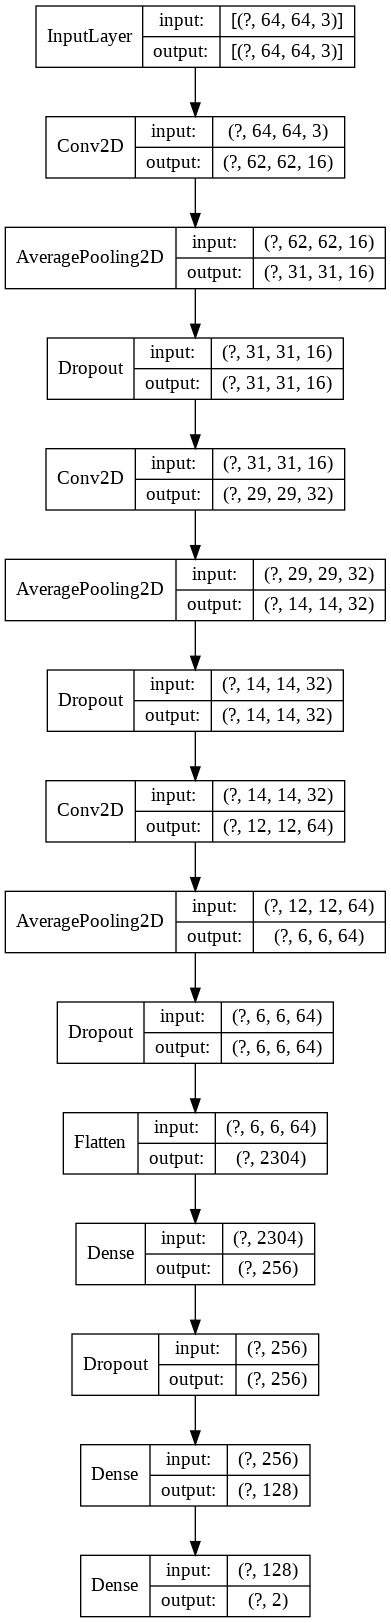

In [16]:
plot_model(model, to_file='model_small.png', show_layer_names=False, show_shapes=True)

# Inicio de entrenamiento

In [ ]:
history = model.fit(X, Y, batch_size=32, epochs=100,validation_split=0.3)
# model.fit_generator(datagen.flow(X, Y, batch_size=32),
#                     epochs=100,
#                     verbose=1)


In [18]:
model.save('TrainedModels/Fire-64x64-color-v7.1-soft.h5')

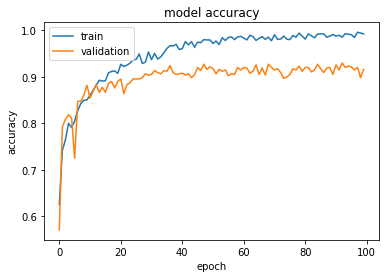

In [19]:
from matplotlib import pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

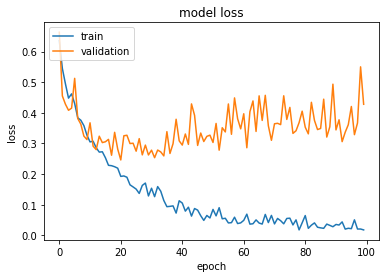

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Datos de prueba

In [56]:
DATADIR = 'Test Dataset'
training_data = create_training_data()

100%|██████████| 278/278 [00:07<00:00, 36.74it/s]


In [52]:
!ls

Fire  NoFire


In [ ]:
#!unzip 'Test Dataset.zip'

In [57]:
len(training_data)

871

# Pruebas de rendimiento

In [64]:
import random
from sklearn.metrics import confusion_matrix
import itertools


test_image_num=871
print(len(training_data))
random.shuffle(training_data)
test_labels=np.zeros((test_image_num,1))

c=0
for sample in training_data:
    test_labels[c]=(sample[1])
    c+=1
print(c)
actual_labels=(test_labels.reshape(test_image_num,))
print(actual_labels.shape)
actual_labels.astype(int)

871
871
(871,)


array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,

In [59]:
X = []
Y = []

for features,label in training_data:
    X.append(features)
    Y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
X = X/255.0
X.shape[1:]

(64, 64, 3)

In [60]:
predicted_labels=model.predict_classes(X)
predicted_labels=(predicted_labels.reshape(test_image_num,))
predicted_labels.astype(int)

array([0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1,

Confusion matrix, without normalization
[[331 262]
 [158 120]]


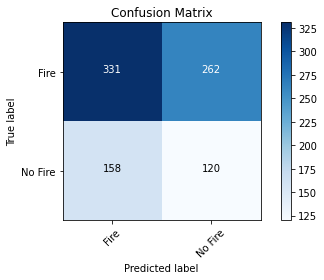

In [65]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(actual_labels, predicted_labels)
#test_batches.class_indices
cm_plot_labels=['Fire','No Fire']
plot_confusion_matrix(cm, cm_plot_labels,title='Confusion Matrix')

In [66]:
tp=cm[0][0]
fn=cm[0][1]
fp=cm[1][0]
tn=cm[1][1]
print("tp"+' '+str(tp))
print("fn"+' '+str(fn))
print("fp"+' '+str(fp))
print("tn"+' '+str(tn))

tp 331
fn 262
fp 158
tn 120


In [67]:
Recall=tp/(tp+fn)
Precision=tp/(tp+fp)
f_measure= 2*((Precision*Recall)/(Precision+Recall))

print(Precision, Recall, f_measure)

0.6768916155419223 0.5581787521079258 0.6118299445471349


In [68]:
model.evaluate(X, Y)

871/871 [==============================] - 0s 131us/sample - loss: 0.7043 - acc: 0.7887


[0.704271872747095, 0.78874856]